# W207 Summer 2018 Final Project 
---

**Authors:** Divya Gorantla, Ram Iyer, Tiffany Jaya, Steve Sanders <br/>
**Date:** 5 August 2018

---

## Table of Contents

1. [Introduction](#introduction)
2. [Exploratory Data Analysis](#eda)
  1. [Load libraries](#load-libraries)
  2. [Load data](#load-data)
  3. [Identify the train labels](#identify-the-train-labels)
  4. [Identify the train features](#identify-the-train-features)
  5. [Address concerns about the datasets](#address-concerns-about-the-datasets)
  
---

<a id='introduction'/>

## Introduction

Our goal in this project is to classify an observed 30 x 30 meter land into one of the seven forest cover types found in the Roosevelt National Forest of Northern Colarado: 

| Forest Cover Type  | Tree   | Leaf  | 
| ------------------ |:------:| -----:| 
| Spruce/Fir         | <img src='./img/spruce-tree.jpg' alt='Spruce tree' height='65px' width='65px'/><br /><img src='./img/fir-tree.jpg' alt='Fir tree' height='65px' width='65px'/> | <img src='./img/spruce.jpg' alt='Spruce leaf' height='65px' width='65px'/><br /><img src='./img/fir.jpg' alt='Fir leaf' height='65px' width='65px'/> | 
| Lodgepole Pine     | <img src='./img/lodgepole-pine-tree.jpg' alt='Lodgepole Pine tree' height='65px' width='65px'/> | <img src='./img/lodgepole-pine.jpg' alt='Lodgepole Pine leaf' height='65px' width='65px'/> | 
| Ponderosa Pine     | <img src='./img/ponderosa-pine-tree.jpg' alt='Ponderosa Pine tree' height='65px' width='65px'/> | <img src='./img/ponderosa-pine.jpg' alt='Ponderosa Pine leaf' height='65px' width='65px'/> |
| Cottonwood/Willow  | <img src='./img/cottonwood-tree.jpg' alt='Cottonwood tree' height='65px' width='65px'/><br /><img src='./img/willow-tree.jpg' alt='Willow tree' height='65px' width='65px'/> | <img src='./img/cottonwood.jpg' alt='Cottonwood leaf' height='65px' width='65px'/><br /><img src='./img/willow.jpg' alt='Willow leaf' height='65px' width='65px'/> |
| Aspen              | <img src='./img/aspen-tree.jpg' alt='Aspen tree' height='65px' width='65px'/> | <img src='./img/aspen.jpg' alt='Aspen leaf' height='65px' width='65px'/> | 
| Douglas-Fir        | <img src='./img/douglas-fir-tree.jpg' alt='Douglas-Fir tree' height='65px' width='65px'/> | <img src='./img/douglas-fir.jpg' alt='Douglas-Fir leaf' height='65px' width='65px'/> | 
| Krummholz <br />(stunted trees) | <img src='./img/krummholz-tree.jpg' alt='Krummholz tree' height='65px' width='65px'/> | |

Fortunately for us, 15,120 of these observations have been labeled to their respective forest cover types. We can then use this labeled dataset to train several different models and compare which model can best accurately classify the forest cover type based on just the cartographic information. 

What we have found is that random forest classifier perform best among the three models we have tested with an accuracy score of 77.2%.  


<a id='eda'/>

## Exploratory Data Analysis

All cartographic information that we use as features to determine the forest cover type has been collected by the US Geological Survey (USGS) and US Forest Service (USFS). The associating labels were derived separately by the USFS Region 2 Resource Information System. We download them from the Kaggle website via the Kaggle API. 

<a id='load-libraries'/>

### Load libraries

In [138]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from pandas.plotting import scatter_matrix   

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

<a id='load-data'/>

### Load data

We used the Kaggle API to download the data directly from the Kaggle website. 

To use the Kaggle API, please follow these instructions:

1. Login to your Kaggle account
2. Select 'My account'
3. Select 'Create New API Token'
4. Place the token 'kaggle.json' into ~/.kaggle

We decided to comment out the code relating to the use of Kaggle API since it was tested in a MAC OS and cannot guarantee reliability in other OS.

In [6]:
# install the Kaggle API library
#!pip install kaggle

# download each ZIP file from the Kaggle website via the Kaggle API
#!kaggle competitions download -c forest-cover-type-prediction -p ./data 

# define each downloaded file
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'
SAMPLE_SUBMISSION_FILENAME = 'sampleSubmission.csv'

# define where the downloaded file will be stored
DATAPATH = './data/'

# unzip the files and load them as a panda DataFrame
def get_data(filename, unzip=False):
    '''Read CSV file (unzip or not) into a dataframe'''
    if unzip:
        zippath = DATAPATH + filename + '.zip'
        return pd.read_csv(zippath, compression='zip', header=0, sep=',', quotechar='"', index_col='Id')
    
    filepath = DATAPATH + filename
    return pd.read_csv(filepath, header=0, sep=',', quotechar='"', index_col='Id')

train = get_data(TRAIN_FILENAME, unzip=False)
test = get_data(TEST_FILENAME, unzip=False)
sample = get_data(SAMPLE_SUBMISSION_FILENAME, unzip=False)

In [148]:
# define labels for the train data
train_labels = train['Cover_Type']
# define additional labels, not defined in the dataset
cover_types = sorted(pd.unique(train['Cover_Type'])) # 1-7
cover_labels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
wilderness_types = list(range(1,5)) # 1-4
wilderness_labels = ['Rawah', 'Neota', 'Comanche', 'Cache la Poudre']
soil_types = list(range(1,41)) # 1-40
soil_labels = ['Cathedral family', 
               'Vanet', 
               'Haploborolis', 
               'Ratake family',
               'Vanet family',
               'Vanet - Wetmore families',
               'Gothic family',
               'Supervisor',
               'Troutville family',
               'Bullwark - Catamount families',
               'Bullwark - Catamount families',
               'Legault family',
               'Catamount family',
               'Pachic Argiborolis',
               '',
               'Cryaquolis',
               'Gateview family',
               'Rogert family',
               'Typic Cryaquolis',
               'Typic Cryaquepts',
               'Typic Cryaquolls',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Granile',
               'Leighcan family',
               'Leighcan family',
               'Como - Legault families',
               'Como family',
               'Leighcan - Catamount families',
               'Catamount family',
               'Leighcan - Catamount families',
               'Cryorthents',
               'Cryumbrepts',
               'Bross family',
               'Cryumbrepts',
               'Leighcan - Moran families',
               'Moran family - Cryorthents',
               'Moran family - Cryorthents'
              ]
soil_descriptions = ['Rock outcrop complex, extremely stony',
                     'Ratake families complex, very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, stony',
                     '',
                     'Limber families complex',
                     'very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock land complex, rubbly',
                     ' Rock land complex, stony',
                     'Rock land - Bullwark family complex, rubbly',
                     'Aquolis complex',
                     '',
                     'Cryoborolis complex',
                     'Cryaquolis complex',
                     'very stony',
                     'Borohemists complex',
                     'Typic Cryaquolls complex',
                     'Leighcan family, till substratum complex',
                     'till substratum, extremely bouldery',
                     'till substratum, extremely bouldery',
                     'extremely stony',
                     'warm, extremely stony',
                     'Catamount families complex, very stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'complex, extremely stony',
                     'Rock land - Legault family complex, extremely stony',
                     'complex, extremely stony',
                     'Rock outcrop - Leighcan family complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock land complex, extremely stony',
                     'Rock outcrop - Cryaquepts complex',
                     'Rock land - Cryumbrepts complex, extremely stony',
                     'Cryumbrepts - Cryorthents complex, extremely stony',
                     'Cryaquolls complex, extremely stony',
                     'Cryorthents - Leighcan family complex, extremely stony',
                     'Cryorthents - Rock land complex, extremely stony'
                    ]
continuous_vars = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

<a id='identify-the-train-labels'/>

### Identify the train labels

There are 2,160 observations for each of the seven forest cover types. The classes are represented equally, which is great news, because we do not have to concern ourselves with misleading classification accuracy, a common problem that plagues an imbalanced dataset.

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

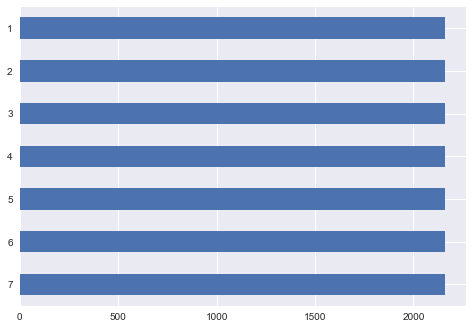

In [57]:
train['Cover_Type'].value_counts().plot(kind='barh')
train['Cover_Type'].value_counts()

<a id='identify-the-train-features'/>

### Identify the train features

In the training dataset, there are 15,120 observations which includes the following 54 features plus the training label "Cover_Type." 

In [63]:
print(train.shape)
train.columns

(15120, 55)


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In the testing dataset, there are 565,892 observations which includes the 54 features found in the training dataset. In other words, we have validated that the training dataset is a good dataset to use as it shares the same cartographic information as the testing dataset.

In [26]:
print(test.shape)
test.columns

(565892, 54)


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [20]:
list(set(train.columns) - set(test.columns))

['Cover_Type']

Looking at the features, it is interesting to note that we do not see longitude and latitude values, which means we cannot validate the cartographic information to the actual geographic location. The 54 features are summarized in the following table below:

| Name                               | Measurement     | Description                                               |
| ----------------------------------:| ---------------:| ---------------------------------------------------------:|
| Elevation                          | meters          | Height above sea level                                    |
| Aspect                             | degrees azimuth | Compass direction that a slope faces<br/>0: North, 90: East, 180: South, 270: West<br/>Potential influence on temperature and soil | 
| Slope                              | degrees         | Degree of incline of a surface<br/>In other words, maximum rate of change of elevation<br/>Has gradient and aspect as components                                                     | 
| Horizontal_Distance_To_Hydrology   | meters          | Horizontal Distance to the nearest surface water features | 
| Vertical_Distance_To_Hydrology     | meters          | Vertical Distance to the nearest surface water features   | 
| Horizontal_Distance_To_Roadways    | meters          | Horizontal distance to the nearest roadway                | 
| Horizontal_Distance_To_Fire_Points | meters          | Horizontal distance to the nearest wildfire ignition points | 
| Hillshade_9am                      | 0 (dark) to 255 (light) | Hillshade index at 9 AM, summer solstice | 
| Hillshade_Noon                     | 0 (dark) to 255 (light) | Hillshade index at 12 PM, summer solstice | 
| Hillshade_3pm                      | 0 (dark) to 255 (light) | Hillshade index at 3 PM, summer solstice | 
| Wilderness_Area (4 binary columns) | 0 (absent) or 1 (present) | Wilderness area designation<br/>1: Rawah, 2: Neota, 3: Comanche, 4: Cache la Poudre | 
| Soil_Type (40 binary columns)      | 0 (absent) or 1 (present) | Soil type designation |



<a id='address-concerns-about-the-datasets'/>

### Address concerns about the datasets

In order for us to confidently apply the datasets onto the models, we first take a look at the size of the training set and compare it to the test set. Unfortunately, the number of observations in the training set is substantially fewer than the number of observations in the test set. With less training data, the parameter estimates that we determined from our models can have greater variance in the accuracy prediction. On a positive note, if we are more concerned about estimating the actual error of our model, having a bigger test set can help in achieving this. For this reason, we consider it to be not a substantial issue to use the training dataset despite the size difference.

In [144]:
# compare the relative sizes of the train and test dataset
train_size = train.shape[0]
test_size = test.shape[0]
total_size = train_size + test_size
print('percentage of train dataset: {:.2f}%'.format(train_size/total_size*100))
print('percentage of test dataset: {:.2f}%'.format(test_size/total_size*100))

percentage of train dataset: 2.60%
percentage of test dataset: 97.40%


With no apparent missing values or outliers, we can move on to the univariate analysis of our data.

any missing values? False


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


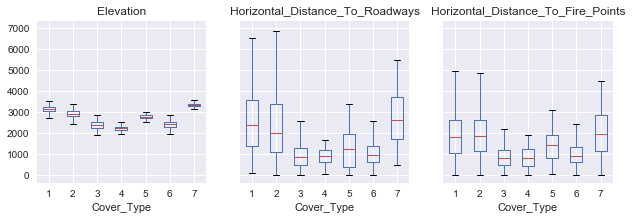

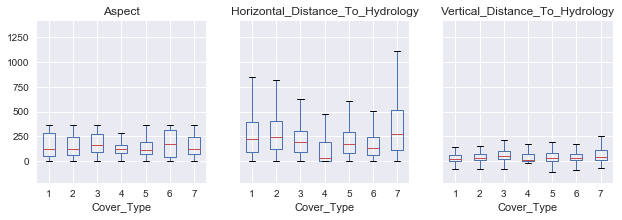

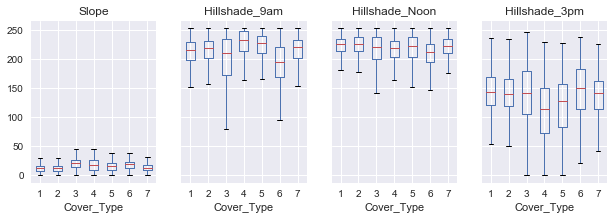

In [143]:
# describe the dataset to see any outliers or missing values
print('any missing values? {}'.format(train.isnull().sum().sum() > 0))
train.boxplot(column=['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points'], by='Cover_Type', layout=(1,3), figsize=(10,3));plt.suptitle('')
train.boxplot(column=['Aspect', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], by='Cover_Type', layout=(1,3), figsize=(10,3));plt.suptitle('')
train.boxplot(column=['Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'], by='Cover_Type', layout=(1,4), figsize=(10,3));plt.suptitle('')
train.describe()

### Univariate analysis

By overlaying the histogram for each forest cover type, we can immediately see that elevation will play a great role in identifying the cover types because the cover types rarely overlaps each other compared to the other features.

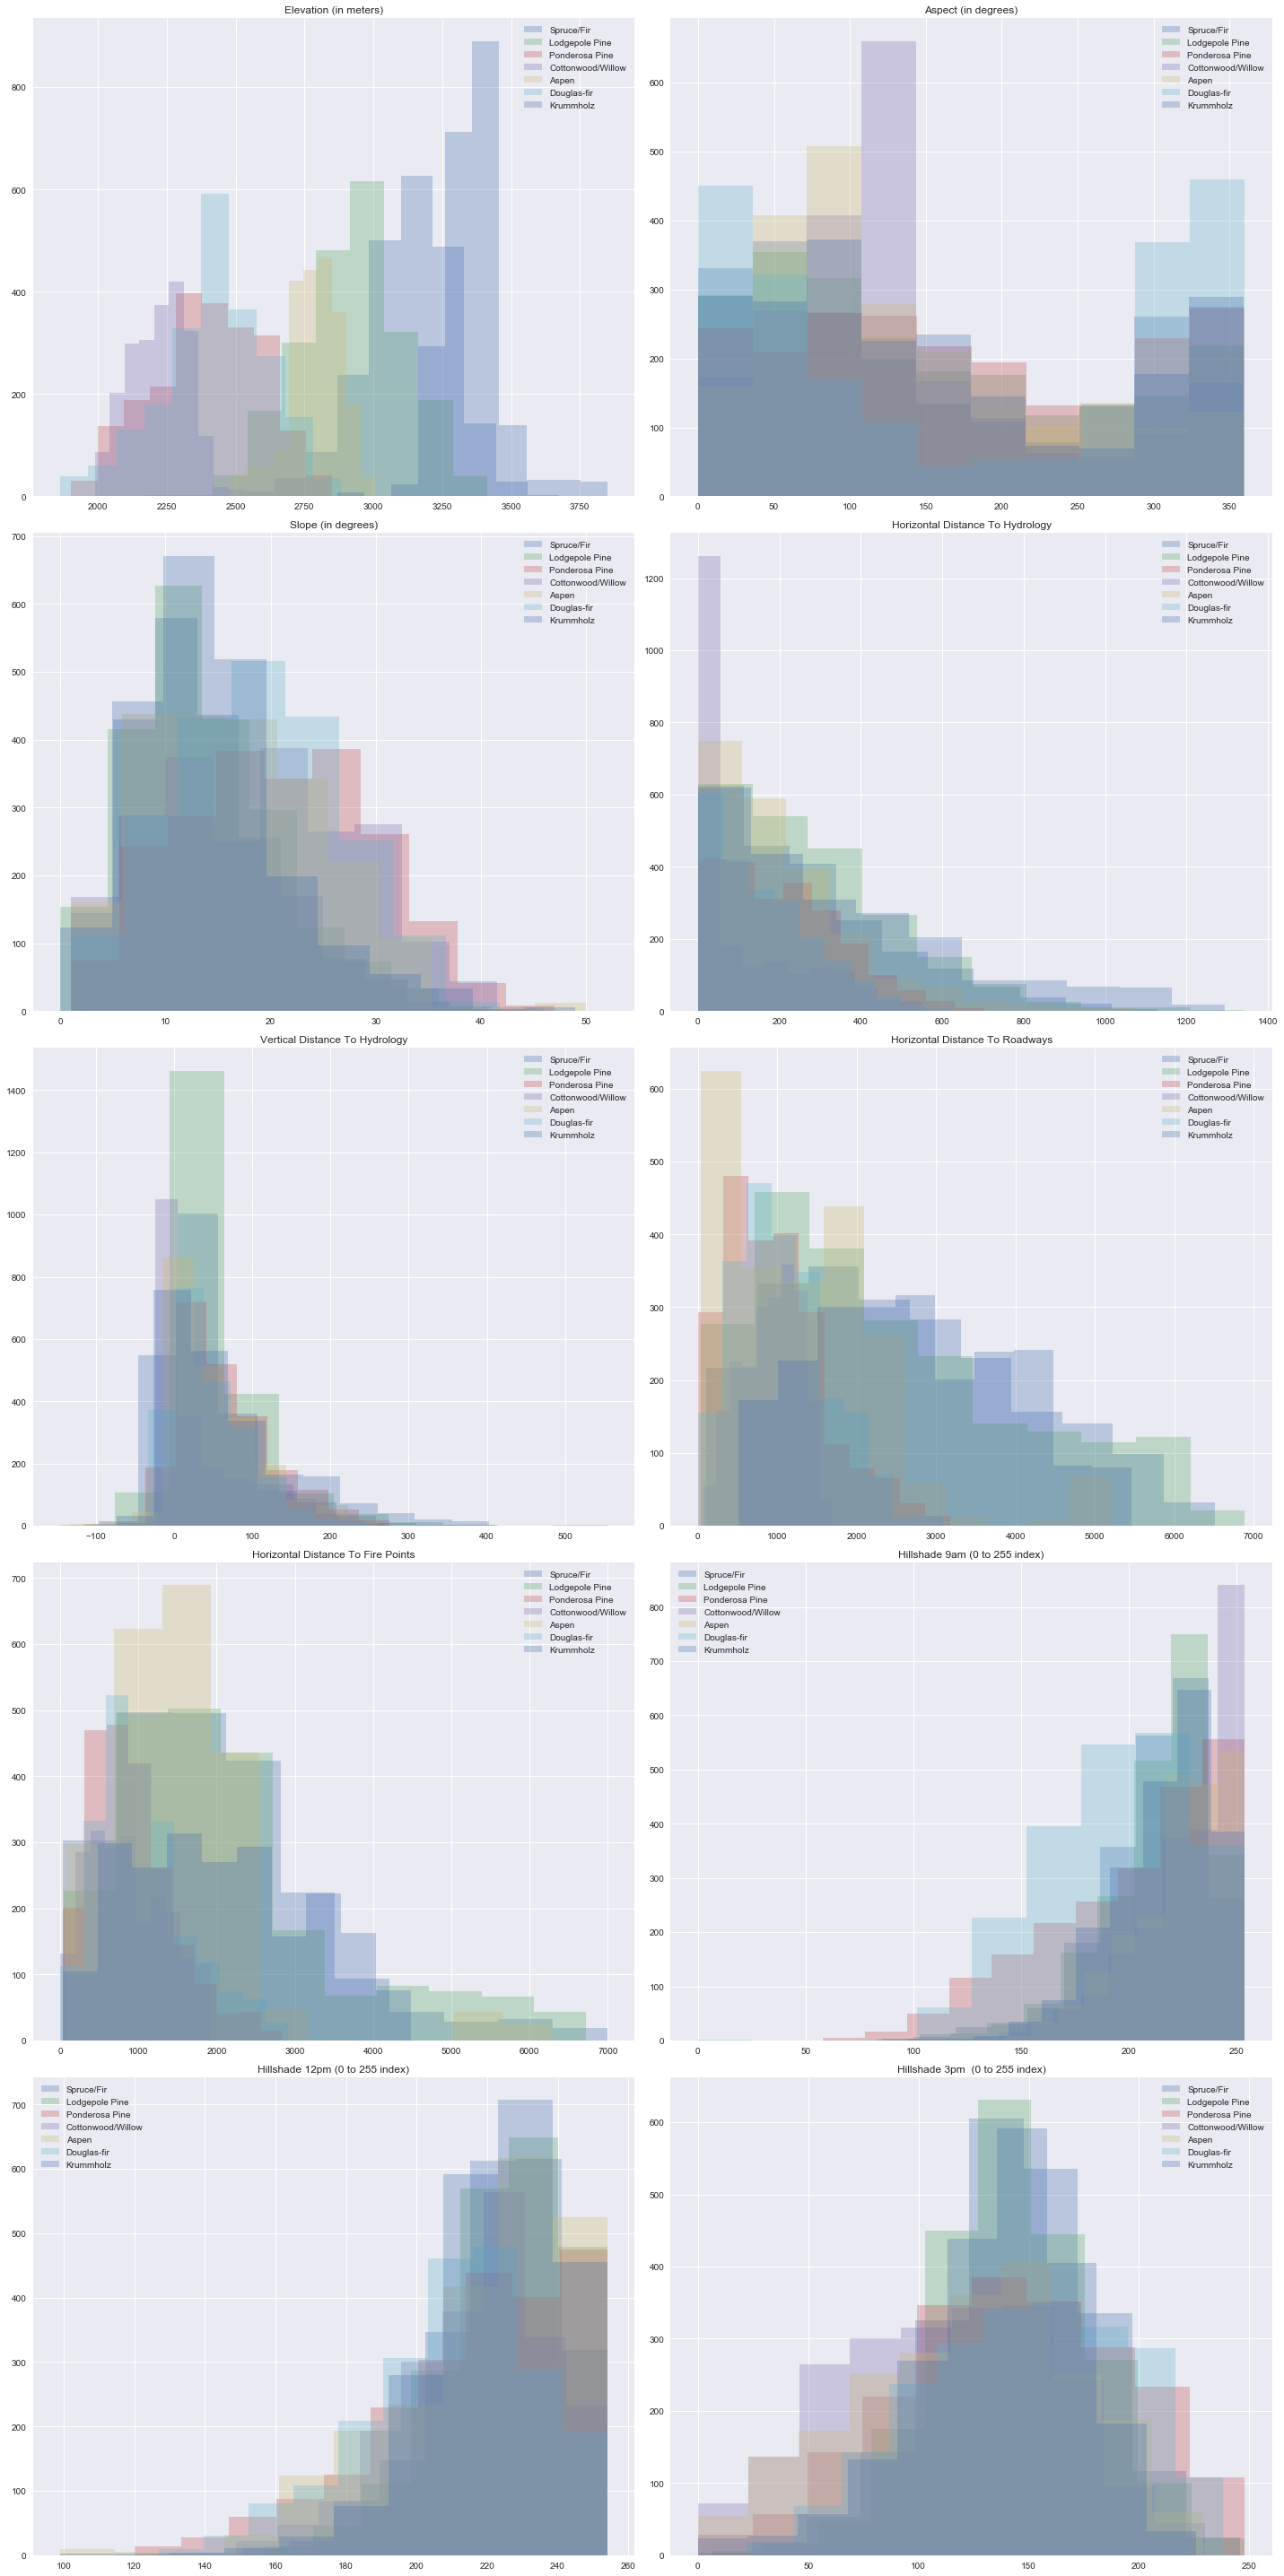

In [164]:
# plot histogram for each continuous variables
nrows = 5
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,40))
(ax_elevation, 
 ax_aspect, 
 ax_slope, 
 ax_hd_h20, 
 ax_vd_h20, 
 ax_hd_roadways, 
 ax_hd_firepoints, 
 ax_hillshade_9am, 
 ax_hillshade_12pm, 
 ax_hillshade_3pm)= axes.flatten() 

for label, data in train.groupby('Cover_Type')['Elevation']:
    data.hist(alpha=0.3, ax=ax_elevation)
ax_elevation.set_title('Elevation (in meters)')
ax_elevation.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Aspect']:
    data.hist(alpha=0.3, ax=ax_aspect)
ax_aspect.set_title('Aspect (in degrees)')
ax_aspect.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Slope']:
    data.hist(alpha=0.3, ax=ax_slope)
ax_slope.set_title('Slope (in degrees)')
ax_slope.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Horizontal_Distance_To_Hydrology']:
    data.hist(alpha=0.3, ax=ax_hd_h20)
ax_hd_h20.set_title('Horizontal Distance To Hydrology')
ax_hd_h20.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Vertical_Distance_To_Hydrology']:
    data.hist(alpha=0.3, ax=ax_vd_h20)
ax_vd_h20.set_title('Vertical Distance To Hydrology')
ax_vd_h20.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Horizontal_Distance_To_Roadways']:
    data.hist(alpha=0.3, ax=ax_hd_roadways)
ax_hd_roadways.set_title('Horizontal Distance To Roadways')
ax_hd_roadways.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Horizontal_Distance_To_Fire_Points']:
    data.hist(alpha=0.3, ax=ax_hd_firepoints)
ax_hd_firepoints.set_title('Horizontal Distance To Fire Points')
ax_hd_firepoints.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Hillshade_9am']:
    data.hist(alpha=0.3, ax=ax_hillshade_9am)
ax_hillshade_9am.set_title('Hillshade 9am (0 to 255 index)')
ax_hillshade_9am.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Hillshade_Noon']:
    data.hist(alpha=0.3, ax=ax_hillshade_12pm)
ax_hillshade_12pm.set_title('Hillshade 12pm (0 to 255 index)')
ax_hillshade_12pm.legend(labels=cover_labels)

for label, data in train.groupby('Cover_Type')['Hillshade_3pm']:
    data.hist(alpha=0.3, ax=ax_hillshade_3pm)
ax_hillshade_3pm.set_title('Hillshade 3pm  (0 to 255 index)')
ax_hillshade_3pm.legend(labels=cover_labels)

fig.tight_layout()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1196a6be0>,
      dtype=object)

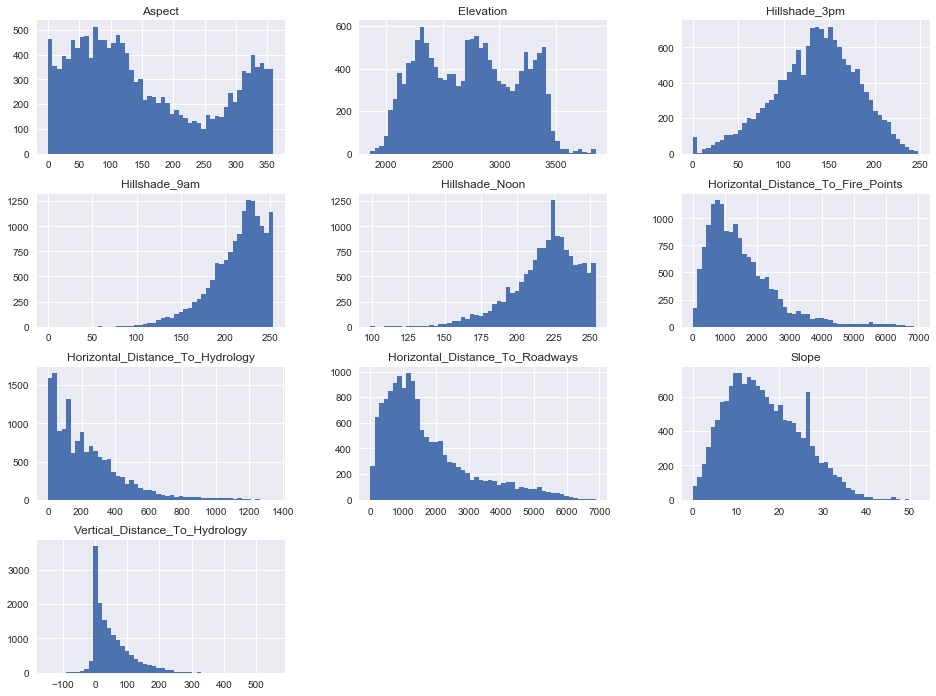

In [69]:
# Look at the continuous features:
train.iloc[:,:10].hist(figsize=(16,12),bins=50)

#### Elevation

In [145]:
# range of Elevation for each cover type
for i in cover_types:
 print ("cover_type %s Elevation range: [%s,%s]" %(i,train[train["Cover_Type"] == i].Elevation.min(),train[train["Cover_Type"] == i].Elevation.max()))

cover_type 1 Elevation range: [2525,3675]
cover_type 2 Elevation range: [2169,3413]
cover_type 3 Elevation range: [1903,2850]
cover_type 4 Elevation range: [1989,2526]
cover_type 5 Elevation range: [2482,3007]
cover_type 6 Elevation range: [1863,2883]
cover_type 7 Elevation range: [2870,3849]


From the graph shown above, it appears that the cover types most commonly found at the high altitude is Krummholz (which is not surprising because Krummholz are stunted windblown trees situated typically on the top of the mountain) followed by the following cover types found in descending order of altitudes:

  - Krummholz
  - Spruce/Fir 
  - Lodgepole Pine
  - Aspen
  - Ponderosa Pine 
  - Douglas-fir
  - Cottonwood/Willow

#### Aspect

From the polar plot, it reconfirms that elevation plays a greater role in identifying the cover type. There's a cover type in almost every aspect (360 degree).

Other plot that we might want to try: https://stackoverflow.com/questions/45396750/matplotlib-azimuth-vs-elevation-discontinuity-at-origin

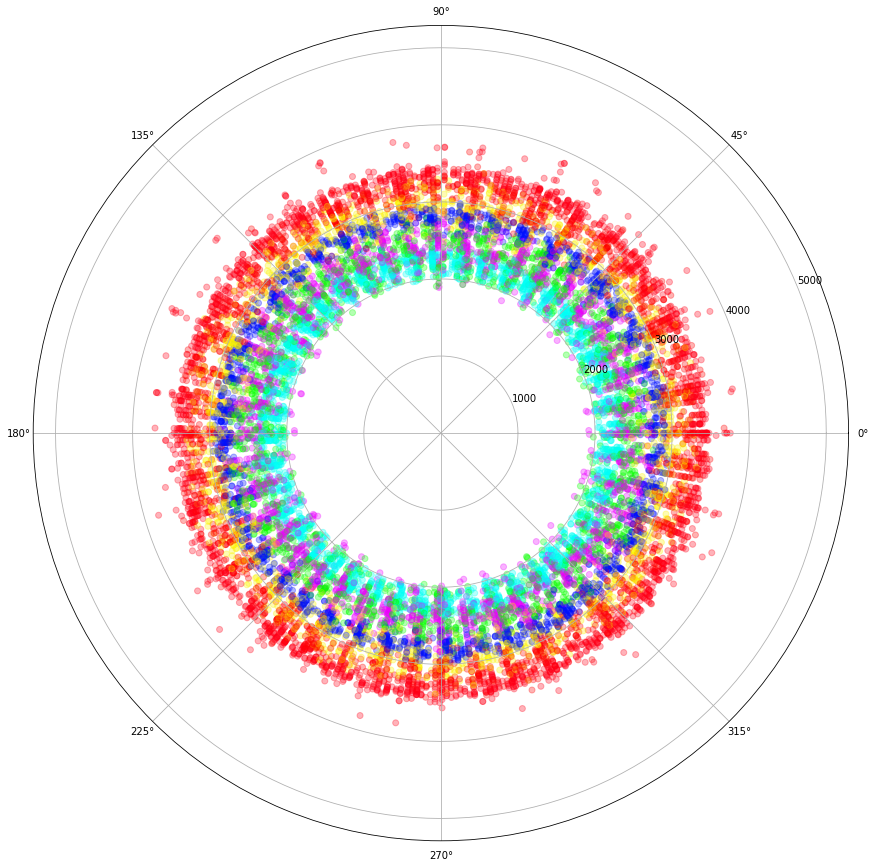

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
ax = plt.subplot(111, projection='polar')
_ = ax.scatter(train['Aspect'], train['Elevation'], c=train['Cover_Type'], cmap='hsv', alpha=0.3)

#### Wilderness area

Based on wilderness area, we noted that: 

* Spruce/Fir (1) is located in Rawah (1), Neota (2), Comanche (3)
* Lodgepole Pine (2) is located in all wilderness area, with the most notable in Rawah (1) and Comanche (2)
* Ponderosa Pine (3) is located in Comanche (3) and Cache la Poudre(4)
* Cottonwood/Willow (4) is located only in Cache la Poudre (4)
* Aspen (5) is located in Rawah (1) and Comanche (3)
* Douglas-fir (6) is located in Comanche (3) and Cache la Poudre (4)
* Krummholz (7) is located in Cover (1), Neota (2), Comanche (3)

For this reason, wilderness area is a substantial feature to use to determine a cover type.


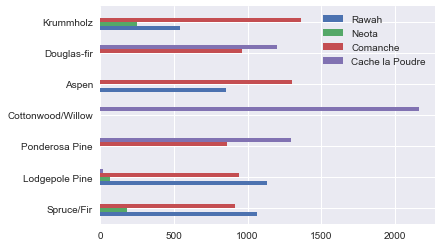

In [151]:
freq_ct_wilderness_1 = pd.crosstab(train['Wilderness_Area1'], train['Cover_Type']).iloc[1].tolist()
freq_ct_wilderness_2 = pd.crosstab(train['Wilderness_Area2'], train['Cover_Type']).iloc[1].tolist()
freq_ct_wilderness_3 = pd.crosstab(train['Wilderness_Area3'], train['Cover_Type']).iloc[1].tolist()
freq_ct_wilderness_4 = pd.crosstab(train['Wilderness_Area4'], train['Cover_Type']).iloc[1].tolist()
freq_ct_wilderness = pd.DataFrame([freq_ct_wilderness_1, freq_ct_wilderness_2, freq_ct_wilderness_3, freq_ct_wilderness_4], 
                                  columns=cover_labels, 
                                  index=wilderness_labels)
freq_ct_wilderness.T.plot(kind='barh', stacked=False)

#### Soils

As you can see below, each cover type sits on a broad range of soils. In addition, there seems to be repeated types of soil separated into multiple categories. For this reason, soil is not a good feature to determine cover types.

During our analysis, we ignore soil type 7 and 15 because these soil types are absent in our sample.

In [156]:

print(pd.unique(train['Soil_Type7']))
print(pd.unique(train['Soil_Type15']))

[0]
[0]


In [158]:
list_freq_ct_wilderness = []
for i in soil_types:
    # ignore soil type: 7, 15
    if i not in (7, 15):
        soil_type = 'Soil_Type{}'.format(i)
        pd.crosstab(train[soil_type], train['Cover_Type']).iloc[1].tolist()
        list_freq_ct_wilderness.append(pd.crosstab(train[soil_type], train['Cover_Type']).iloc[1].tolist())

soil_labels_wo_7_15 = [soil_label for ignore_label, soil_label in enumerate(soil_labels) if ignore_label not in [7,15]]
freq_ct_soil = pd.DataFrame(list_freq_ct_wilderness, 
                            columns=cover_labels, 
                            index=soil_labels_wo_7_15)
freq_ct_soil

,Spruce/Fir,Lodgepole Pine,Ponderosa Pine,Cottonwood/Willow,Aspen,Douglas-fir,Krummholz
Cathedral family,0,0,121,139,0,95,0
Vanet,0,3,283,94,61,182,0
Haploborolis,0,12,133,799,0,18,0
Ratake family,5,20,462,133,129,87,7
Vanet family,0,0,55,39,0,71,0
Vanet - Wetmore families,0,7,248,244,0,151,0
Gothic family,0,1,0,0,0,0,0
Troutville family,1,9,0,0,0,0,0
Bullwark - Catamount families,9,81,717,170,64,1101,0
Bullwark - Catamount families,5,67,89,24,154,67,0


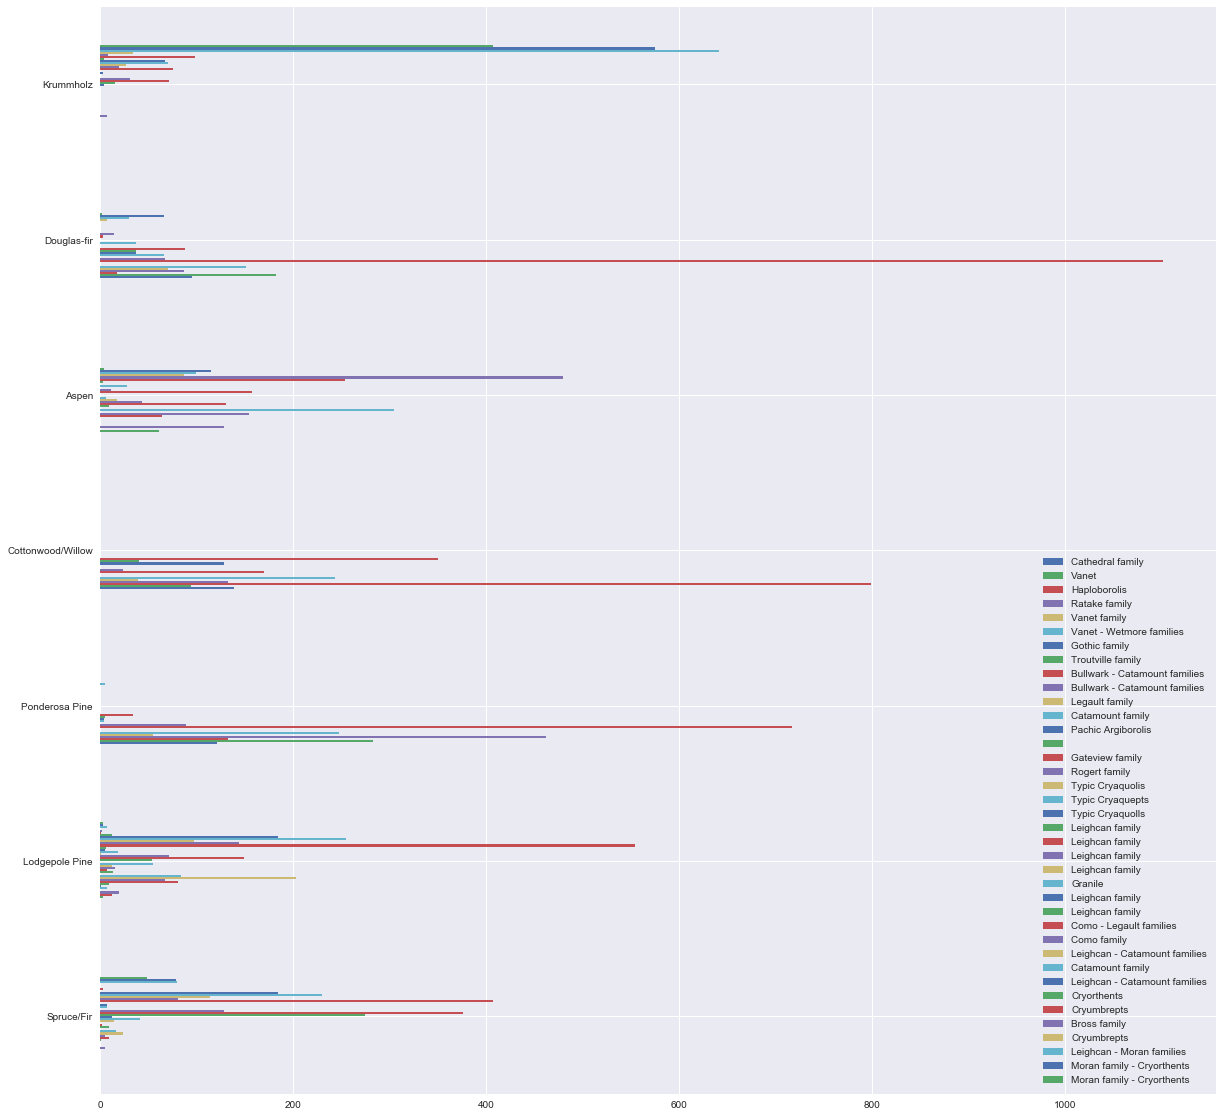

In [160]:
freq_ct_soil.T.plot(kind='barh', stacked=False, figsize=(20,20))

### Observations from histograms of continuous-variable features:
Aspect is rotational, so the value at 360 degrees should equal the value at 0 degrees.  (This represents the compass direction that the slope (surface of the hill) faces, based on azimuth angle, where 0 degrees is North and 90 degrees is East.)  

Elevation appears to have 3 modes.  

Hillshade_3pm has several zero values that appear to be out of place (i.e., "missing values"). 
Hillshade_9am and Hillshade_Noon are truncated at 255, which is the maximum value of the index.  

The distance-based features have substantial right-hand skew.   

Slope appears to have extra data at a value around 27 degrees.  

Vertical_Distance_to_Hydrology has several negative values.  


In [165]:
train[continuous_vars].corr()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Hillshade_9am,Hillshade_Noon,Hillshade_3pm
Elevation,1.000000,-0.011096,-0.312640,0.412712,0.122092,0.578659,0.443563,0.097900,0.215782,0.089518
Aspect,-0.011096,1.000000,0.028148,0.040732,0.056412,0.066184,-0.052169,-0.593997,0.324912,0.635022
Slope,-0.312640,0.028148,1.000000,-0.055976,0.265314,-0.277049,-0.239527,-0.200072,-0.612613,-0.326887
Horizontal_Distance_To_Hydrology,0.412712,0.040732,-0.055976,1.000000,0.652142,0.203397,0.158817,-0.033803,0.080047,0.080833
Vertical_Distance_To_Hydrology,0.122092,0.056412,0.265314,0.652142,1.000000,0.011555,-0.015048,-0.095930,-0.132948,-0.035559
Horizontal_Distance_To_Roadways,0.578659,0.066184,-0.277049,0.203397,0.011555,1.000000,0.486386,-0.003398,0.240684,0.173882
Horizontal_Distance_To_Fire_Points,0.443563,-0.052169,-0.239527,0.158817,-0.015048,0.486386,1.000000,0.078144,0.122098,0.043162
Hillshade_9am,0.097900,-0.593997,-0.200072,-0.033803,-0.095930,-0.003398,0.078144,1.000000,-0.013712,-0.779965
Hillshade_Noon,0.215782,0.324912,-0.612613,0.080047,-0.132948,0.240684,0.122098,-0.013712,1.000000,0.614526
Hillshade_3pm,0.089518,0.635022,-0.326887,0.080833,-0.035559,0.173882,0.043162,-0.779965,0.614526,1.000000


Axes(0.125,0.125;0.62x0.755)


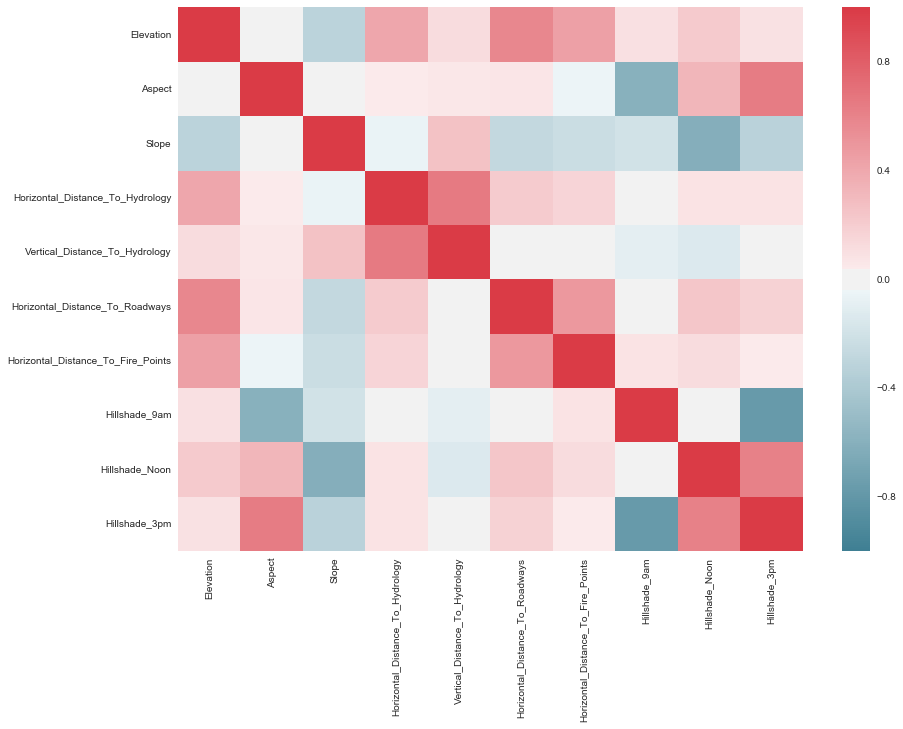

In [166]:
# plot correlation map of continuous features in train data

plt.figure(figsize=(14, 10))
cmap = sb.diverging_palette(220, 10, as_cmap=True)   #Creates a Matplotlib color map
correlations = train[continuous_vars].corr()
# print correlations
print(sb.heatmap(correlations, cmap=cmap))


The hillshade at Noon/ hillshade at 3pm show a high degree of positive correlation
The hillshade at 9AM vs 3pm show a high degree of negative correlation

Aspect has negative correlation with hillshades at 9AM and Noon

Horizontal and Vertical distance to hydrology are highly positively correlated

Slope and hillshade have high correlation

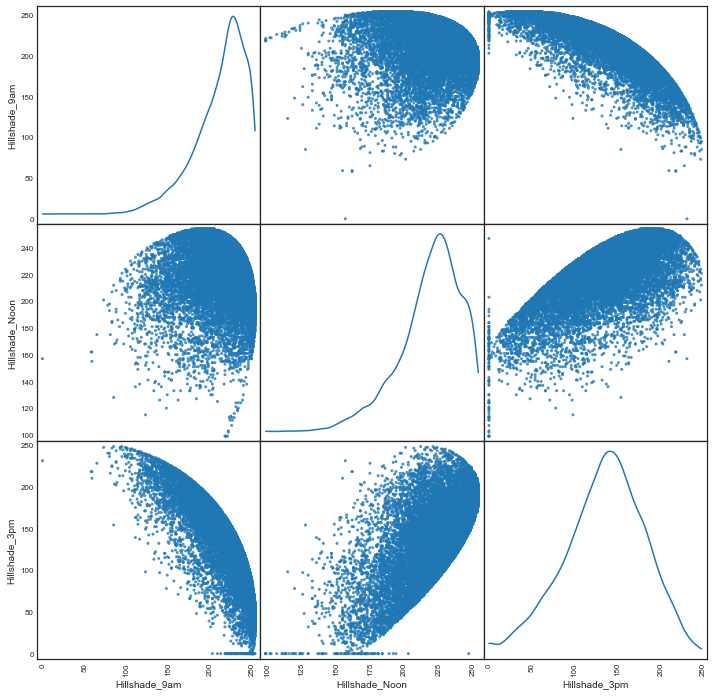

In [34]:
# See how Hillside features are related.

with seaborn.axes_style('white'): 
    hillside = train[['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']] 
    scatter_matrix(hillside, alpha=0.8, figsize=(12, 12), diagonal="kde") 
    plt.show() 

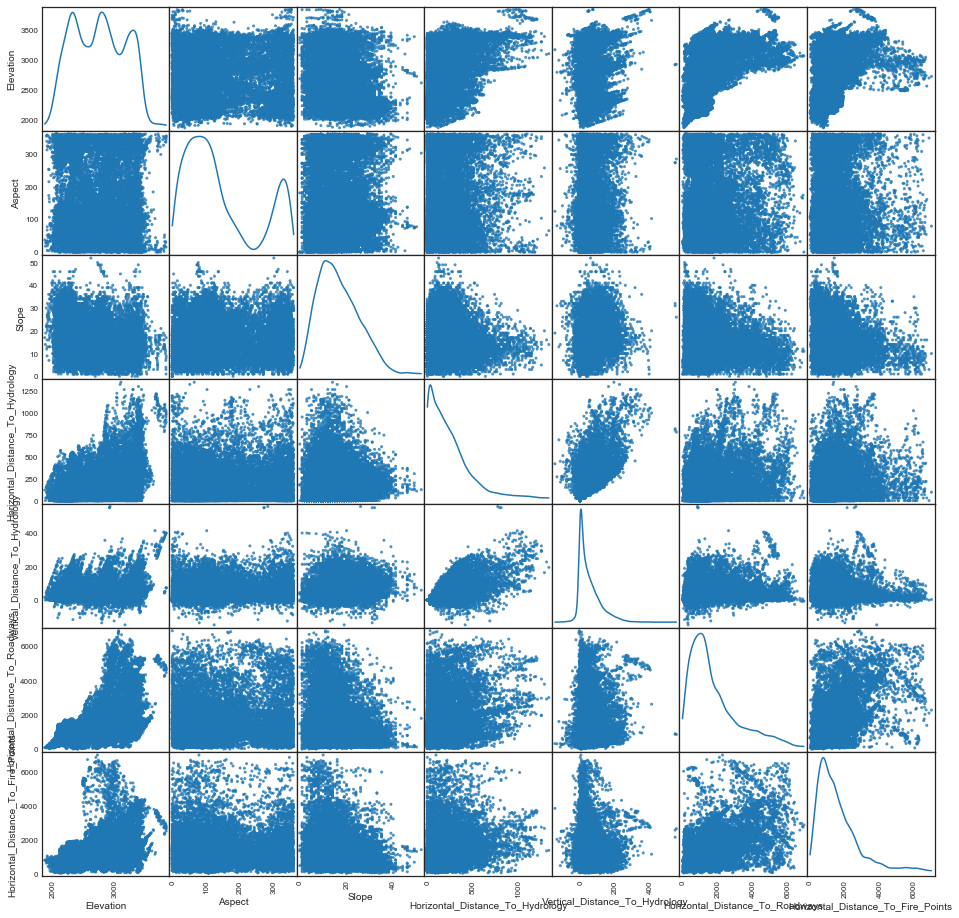

In [37]:
# See how the other continuous features are related.

with seaborn.axes_style('white'): 
    other_cont = train[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']] 
    scatter_matrix(other_cont, alpha=0.8, figsize=(16, 16), diagonal="kde") 
    plt.show()

Several soil types are under-represented, including 7 and 15, which have no representation.

Wilderness_Area2 is under-represented relative to the other 3 Wilderness_Area types.

TODOs:

plot histograms for continuous-variable features  
calculate and plot correlation coefficients from initial dataset (uses just the numerical columns)    
perform initial baseline with Random Forest Classifier
drop features that are highly correlated with other features?  
explore feature normality and potential transformations  
explore new composite and/or modified variables  

## Models

TODO: explain what the models do 


### Random Forest Classifier

In [45]:
X_train = train.iloc[:,:-1].values
y_train = train.iloc[:,-1:].values.ravel()

                                    importance
feature                                       
Elevation                                0.226
Horizontal_Distance_To_Roadways          0.095
Horizontal_Distance_To_Fire_Points       0.074
Horizontal_Distance_To_Hydrology         0.062
Vertical_Distance_To_Hydrology           0.055
Aspect                                   0.050
Hillshade_9am                            0.049
Hillshade_3pm                            0.047
Hillshade_Noon                           0.043
Wilderness_Area4                         0.041
Slope                                    0.036
Soil_Type10                              0.025
Wilderness_Area1                         0.020
Soil_Type3                               0.020
Soil_Type39                              0.019
Soil_Type38                              0.017
Wilderness_Area3                         0.016
Soil_Type4                               0.012
Soil_Type40                              0.010
Soil_Type2   

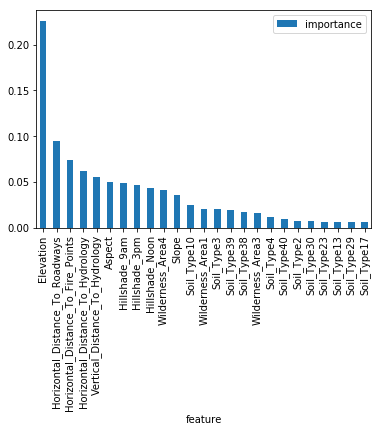

In [48]:
# Sort the features by importance

rf_initial=RandomForestClassifier(n_estimators=40, bootstrap=True, oob_score=True)

rf_initial.fit(X_train,y_train)

best_features = pd.DataFrame({'feature':train.columns[:-1],'importance':np.round(rf_initial.feature_importances_,3)})
best_features = best_features.sort_values('importance',ascending=False).set_index('feature')[:25]

print(best_features)
best_features.plot.bar()

In [ ]:
# Do a randomized search on the initial tree implementation for the baseline model. 
# This model is used for the initial submission


from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier()
param_grid = {'n_estimators':np.linspace(10,50,20,dtype=int), 'max_depth':np.linspace(10,100,20,dtype=int)}

rsearch_tree = RandomizedSearchCV(estimator = model, param_distributions=param_grid,n_iter=50,cv=5)

rsearch_tree.fit(X_train,y_train)
print(rsearch_tree)

In [52]:
print(" Best Estimator, number of trees ",rsearch_tree.best_estimator_.n_estimators)

 Best Estimator, number of trees  50


In [50]:
print(" Best Estimator, max tree depth", rsearch_tree.best_estimator_.max_depth)

 Best Estimator, max tree depth 76


In [49]:
mean_score = np.mean(rsearch_tree.cv_results_['mean_test_score'])
std_score  = np.std(rsearch_tree.cv_results_['mean_test_score'])
print("Mean cross validation score {:7.4f}, std dev of scores :{:7.4f}".format(mean_score,std_score))

Mean cross validation score  0.7682, std dev of scores : 0.0118


In [54]:
# Fit the baseline model with the cross validates params on the original feature set

baseline_model = RandomForestClassifier(n_estimators=50,max_depth=76)
baseline_model.fit(X_train,y_train)

scores = cross_val_score(baseline_model, X_train, y_train,cv=10)

print("Baseline model score, mean : {:7.4f}, stdDev : {:7.4f}".format(np.mean(scores),np.std(scores)))

Baseline model score, mean :  0.7762, stdDev :  0.0412


In [55]:
# Logistic regression with all original features

model = LogisticRegression()
param_grid = {'C':np.linspace(0.1,10,1000)}

rsearch_all = RandomizedSearchCV(estimator = model, param_distributions=param_grid,n_iter=20,cv=10)

rsearch_all.fit(X_train,y_train)
print(rsearch_all)
print()

print("Best estimated C value",rsearch_all.best_estimator_.C)

mean_score = np.mean(rsearch_all.cv_results_['mean_test_score'])
std_score  = np.std(rsearch_all.cv_results_['mean_test_score'])
print("Mean cross validation score {:7.4f}, std dev of scores :{:7.4f}".format(mean_score,std_score))

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'C': array([ 0.1    ,  0.10991, ...,  9.99009, 10.     ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)
Best estimated C value 8.523423423423424
Mean cross validation score  0.6275, std dev of scores : 0.0028


In [57]:

## Try out KNN with the original feature set

k_range = list(range(1,71,2))
weight_options = ['uniform','distance']
param_grid = {"n_neighbors":k_range,"weights":weight_options}

model = KNeighborsClassifier()

%time rsearch_knn = RandomizedSearchCV(estimator = model, param_distributions=param_grid,n_iter=20,cv=10)

rsearch_knn.fit(X_top20,y_top20)

print(rsearch_knn)
print()

print("Best estimated n_neighbors value",rsearch_knn.best_estimator_.n_neighbors)
print("Best estimated weights value",rsearch_knn.best_estimator_.weights)
print()

mean_score = np.mean(rsearch_knn.cv_results_['mean_test_score'])
std_score  = np.std(rsearch_knn.cv_results_['mean_test_score'])
print("Mean cross validation score {:7.4f}, std dev of scores :{:7.4f}".format(mean_score,std_score))

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 16.2 µs
RandomizedSearchCV(cv=10, error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69], 'weights': ['uniform', 'distance']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Best estimated n_neighbors value 1
Best estimated weights value uniform

Mean cross validation score  0.6326, std dev of scores : 0.0409


In [ ]:

# Try out the Support Vector Machine classifier with the original feature set
## Note that this is super slow in terms of training time, so avoid running this cell unless absolutely needed.

from sklearn import svm

param_grid = {
    'C':            np.arange( 1, 10+1, 1 ).tolist(),
    'kernel':       ['linear', 'rbf'],                   
    'gamma':        np.arange( 0.0, 10.0+0.1, 0.1 ).tolist(),
    }

model = svm.SVC()

rsearch_svm = RandomizedSearchCV(estimator = model, param_distributions=param_grid,n_iter=10,cv=10)

rsearch_svm.fit(X_train,y_train)

print(rsearch_svm)
print(rsearch_svm.best_score_)
print(rsearch_svm.best_estimator_.C)
print(rsearch_svm.best_estimator_.kernel)
print(rsearch.svm.best_estimator_gamma)

mean_score = np.mean(rsearch_svm.cv_results_['mean_test_score'])
std_score  = np.std(rsearch_svm.cv_results_['mean_test_score'])
print("Mean cross validation score {:7.4f}, std dev of scores :{:7.4f}".format(mean_score,std_score))

In [56]:

## TODO - SCALE features before trying out Naive Bayes ###

'''
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

alpha = np.geomspace(0.001,10,100)
param_grid = {"multinomialnb__alpha":alpha}

pipe = (StandardScaler(),MultinomialNB)

rsearch_nb = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid,n_iter=50,cv=10)
print(rsearch_nb)

print(X_train.shape)
print(y_train.shape)
print(alpha)
'''

'\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.pipeline import make_pipeline\n\nalpha = np.geomspace(0.001,10,100)\nparam_grid = {"multinomialnb__alpha":alpha}\n\npipe = (StandardScaler(),MultinomialNB)\n\nrsearch_nb = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid,n_iter=50,cv=10)\nprint(rsearch_nb)\n\nprint(X_train.shape)\nprint(y_train.shape)\nprint(alpha)\n'

In [20]:
#Make a copy of the test file 
temp_test = test.copy() 

#Run Predictions on temp_test
temp_test['Cover_Type'] = rsearch_tree.predict(temp_test.values) 


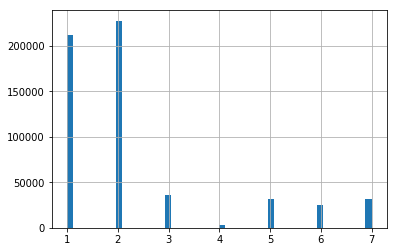

In [21]:
# There are no test labels to compare to, so just plot the distribution of the predicted classes.  

temp_test.Cover_Type.hist(bins=50) 
plt.show()

We observe that the predicted Cover_Type classes from the test data are highly weighted toward Cover_Type's 1 and 2.  

In [27]:

temp_test["Cover_Type"].to_csv('RF-Initial.csv', header=True)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
15121,2680,354,14,0,0,2684,196,214,156,6645,...,0,0,0,0,0,0,0,0,0,2
15122,2683,0,13,0,0,2654,201,216,152,6675,...,0,0,0,0,0,0,0,0,0,2
15123,2713,16,15,0,0,2980,206,208,137,6344,...,0,0,0,0,0,0,0,0,0,1
15124,2709,24,17,0,0,2950,208,201,125,6374,...,0,0,0,0,0,0,0,0,0,2
15125,2706,29,19,0,0,2920,210,195,115,6404,...,0,0,0,0,0,0,0,0,0,1


## Results

What happened

## Discussions

Concluding thoughts

### Observations/Questions 
There are no "null" cells in the train data set.   
Aspect is rotational, so the value at 360 degrees should equal the value at 0 degrees.  
Elevation appears to have 3 modes.  
Hillshade_3pm has several zero values that appear to be out of place (i.e., "missing values"). 
Hillshade_9am and Hillshade_Noon are truncated at 255, which is the maximum value of the index.  
The distance-based features have substantial right-hand skew.   
Slope appears to have extra data at a value around 27 degrees.  
Vertical_Distance_to_Hydrology has several negative values.   
Several soil types are under-represented, including 7 and 15, which have no representation.  
Wilderness_Area2 is under-represented relative to the other 3 Wilderness_Area types.  
Ran a Random Forest Classifier to get an initial baseline.  The RFC fit the train data perfectly. The predicted Cover_Type classes from the test data are highly weighted toward Cover_Type's 1 and 2. 

Are we assuming this data were all collected "simultaneously"?  If collected over a number of weeks/months, then I would expect a time dependence, particularly with the Hillside variables.  



### To Do  
submit baseline test predictions to Kaggle to get result of test predictions?  (From Ref 4., expect ~ 0.75 accuracy.)
further examine the binary features; consider consolidation (e.g., perhaps rocky vs. non-rocky soil)?  
quantify missing values  
drop features that are highly correlated with other features?  
explore feature normality and potential transformations (e.g., log transforms)   
explore new composite and/or modified (input) variables  
construct weighting factors to compensate for non-uniform predicted test labels?  
  

## References
1. Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science
2. “Colorado's Major Tree Species.” Colorado State Forest Service, csfs.colostate.edu/colorado-trees/colorados-major-tree-species/#1466527937174-cd5c5e60-5efc.
3. Slope, Aspect, and Hillshade.” GEOG 571: Intelligence Analysis, Cultural Geography, and Homeland Security, www.e-education.psu.edu/geog480/node/490.





1. https://www.kaggle.com/c/forest-cover-type-kernels-only  
2. http://nbviewer.jupyter.org/github/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb  
3. https://cseweb.ucsd.edu/~jmcauley/cse255/reports/wi15/Yerlan_Idelbayev.pdf  
4. https://shankarmsy.github.io/posts/forest-cover-types.html  
5. https://www.fs.fed.us/rm/pubs_other/rmrs_2007_stage_a002.pdf  

